# Vector/k-means based algorithms

These algorithms generally have the following structure:

1: Vectorize documents
2: Cluster documents
3: Evaluate the results
4: Update k
5: Repeat until our evaluation is satisfactory

First we will write some common functions to avoid duplicating too much.

In [1]:
import nltk as n
import analyze_text as atxt
import scipy

def tokenize(text):
    # Remove named entities
    # TODO necessary?
    named_entities = []
    chunked = n.ne_chunk(n.pos_tag(n.word_tokenize(text)))
    for chunk in chunked:
        if type(chunk) == n.tree.Tree:
           ne = ' '.join([token for token, pos in chunk.leaves()])
           text = text.replace(ne, '') # Tokenize
    tokens = atxt.tokenize(text)
    tokens = [token for token in tokens if len(token) >= 4]
    tokens = [atxt.get_lemma(token) for token in tokens if atxt.get_lemma(token)]
    tokens = [token for token in tokens if token.isalpha()]
    return tokens

def mscd(km_matrix):
    sum = 0
    i = 0
    for row1 in km_matrix:
        j = i + 1
        for row2 in km_matrix[j:]:
            sum += scipy.spatial.distance.cosine(row1, row2)**2
        i += 1
    sum *= 2 / (km_matrix.shape[0] * (km_matrix.shape[0] - 1))
    return sum**(1/2.0)

## Doc2Vec

Here we use Doc2Vec (trained on a large external dataset) as the vectorizer, and standard k-means based on cosine distance.

In [5]:
# A naive half-implementation used to plot MSCD at varying k
import os
import numpy as np

K_VALS = [2, 3, 5, 7, 10, 25, 50, 75, 100, 150, 200]
BASE_PATH = '/home/trevor/Projects/iot-diff/iot-tc/'
DATA_CNET_PATH = os.path.join(BASE_PATH, 'cnet-classifications.csv')


### Vectorize
import gensim as g
import pandas as pd

D2V_WIKI_PATH = os.path.join(BASE_PATH, 'enwiki_dbow/doc2vec.bin')

model = g.models.doc2vec.Doc2Vec.load(D2V_WIKI_PATH)
df = pd.read_csv(DATA_CNET_PATH)
df['vec'] = 'N/A'
for i, row in df.iterrows():
    text = row['article_content']
    row['vec'] = model.infer_vector(tokenize(text))
vecs = np.array(df['vec'].tolist())


### Cluster
import spherecluster as sp

mscd_scores = {}
for k in K_VALS:
    skm = sp.SphericalKMeans(n_clusters=k)
    df['cluster'] = skm.fit_predict(vecs)
    mscd_scores[k] = mscd(skm.cluster_centers_)

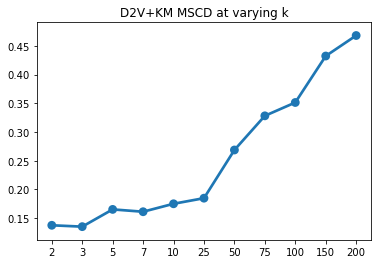

In [12]:
### Visualize
import matplotlib as mpl
import seaborn as sb
%matplotlib inline

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['savefig.facecolor'] = 'white'

pointplt = sb.pointplot(x=K_VALS, y=list(mscd_scores.values()), ymax=1, ymin=0.0)
pointplt.set_title('D2V+KM MSCD at varying k')